<a href="https://colab.research.google.com/github/matansuliman/Introduction-to-Machine-Learning/blob/main/MNIST_PLA%2C_Softmax%2C_and_Linear_Regression_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Details:
*   Name: Matan Suliman

## Overview:


**This is a Multi-Class Handwritten Digit Classification using the MNIST Dataset.**


**This notebook has 3 main parts:**
1.   The Pocket Algorithm
2.   Softmax Regression
3.   Linear Regression

**For each part:**
1.   we define helper function
2.   defining and running the algorithm
3.   plotting the losses
4.   making predictions
5.   building and visualizing the confusion matrix
6.   calculating prefermance matricies
7.   discussing the results


Note: Throught the code we use Vectorized Implementation with numpy library for enhanced computational efficiency and runtime.

## Initialization

###dependencies

**Imports**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

**Global variables**

In [ ]:
K = 10 # number of classes
np.random.seed(42) # ensures reproducibility

###mnist dataset


**Fetch**

In [ ]:
mnist = fetch_openml('mnist_784', version=1)

In [ ]:
X, y = mnist['data'], mnist['target']

**Normalize X**

In [ ]:
X /= 255.0 # each value is now inside [0, 1]

**Add a colmun of 1's to X**
*  Concatenate a columns of 1's of shape (784, ) to the image matrix X of shape (10000, 784)

In [ ]:
X_with_bias = np.c_[np.ones(X.shape[0]), X]

**OneHot encoding vactor of y**
*   Initially y is a vactor of strings, so y.astype(int) converts the vector y to a vector of ints
*   Then we replace each element in y with the i'th row of the identity matrix (K x K)

In [ ]:
y = y.astype(int)
y_onehot = np.eye(K)[y]

**Split dataset to train and test**
*   The MNIST dataset has 70,000 images.
*   We split it into a training set and testing set with ratio 6:1

In [ ]:
X_train, X_test, y_train_onehot, y_test_onehot = train_test_split(X_with_bias, y_onehot, test_size= 1/7, random_state= 42)

##Part A: The Pocket Algorithm

###Define helper function:

The hypothesis function

In [ ]:
def h(w, X):
  """
  The hypothesis function
  params:
    w: weight vector
    X: input matrix
  returns:
    a vector of the sign of the dot products of X and w
  """
  return np.sign(X @ w)

The perceptron learning algorithm (PLA)

In [ ]:
def PLA(w, X, y, iterations=1000, initial_lr = 0.1, decay_rate= 0.94):
  """
  Perceptron Learning Algorithm (PLA)
  params:
    w: weight vector
    X: input matrix
    y: lables vector
    iterations: number of iterations to perform
    initial_lr: initial learning rate
    decay_rate: learning rate decay rate
  returns:
    w_best: weight vector after max_iterations
  """
  lr = initial_lr
  w_best = w.copy()

  for _ in range(iterations):

    predictions = h(w, X)
    errors = predictions != y # a boolean array

    # np.where return the indices where the the bolean array is true
    misclassified_indices = np.where(errors)[0]

    if len(misclassified_indices) == 0: return False

    # pick a random misclassified sample
    rand_idx = np.random.choice(misclassified_indices)

    # update rule
    w_best += lr * y[rand_idx] * X[rand_idx]

    lr *= decay_rate # update learning rate

  return w_best

E(w, X, y): The Error of weight vector (w) on input (X) and lables (y)

In [ ]:
def E(w, X, y):
  """
  Error of weight vector (w) on input (X) and lables (y)
  params:
    w: weight vector
    X: input matrix
    y: lables vector
  returns:
    the mean of the sign of the dot products of X and w where the result is not equal to y
  """
  predictions = h(w, X)
  errors = predictions != y
  N = X.shape[0]

  return np.sum(errors) / N # mean

###The Pocket Algorithm

In [ ]:
def pocket_algorithm(W, X_train, X_test, y_train_onehot, y_test_onehot, epochs=100, initial_lr= 0.01, decay_rate= 0.94):
  """
  Pocket Algorithm for multi-class classification
  params:
    W: weight matrix of shape (K, d+1), weight vectors as rows
    X_train: input matrix of shape (N, d+1)
    X_test: input matrix of shape (N, d+1)
    y_train_onehot: lables matrix of shape (N, K)
    y_test_onehot: lables matrix of shape (N, K)
    epochs: number of epochs to perform
    initial_lr: initial learning rate
    decay_rate: learning rate decay rate
  returns:
    training_losses: list of lists, each list contains the training loss for each class
    test_losses: list of lists, each list contains the test loss for each class
  """
  training_losses = [list() for i in range(K)]
  test_losses = [list() for i in range(K)]

  for i in tqdm(range(K), desc='Outer'): # for each Class

    # y_train_i and y_test_i is the current y labels for the i'th class
    # if the one_hot vector is from the i'th class put label 1
    # for all oher case put label -1
    """y_train = 2 * y_train_onehot[:, i] - 1
    y_test = 2 * y_test_onehot[:, i] - 1"""

    y_train = np.where(y_train_onehot[:, i] == 1, 1, -1)
    y_test = np.where(y_test_onehot[:, i] == 1, 1, -1)

    lr = initial_lr # init lr to calss

    min_error = E(W[i], X_train, y_train)
    print(f"\nClass {i} strting min error {round(min_error *100, 2)} % :", end= "")

    for t in tqdm(range(epochs +1), desc='Inner', leave=False):

      if t %10 == 0:
        training_losses[i].append(min_error)
        test_losses[i].append(E(W[i], X_test, y_test))
        print(f" curr min: {round(min_error *100, 2)} %")

      w_next = PLA(W[i], X_train, y_train, iterations=1, initial_lr= lr) # run PLA for 1 iteration
      if w_next is False: break # breaks inner loop if no more misclassified samples
      current_error = E(w_next, X_train, y_train)

      # update current_error and W[i] if found a better weight vector
      if current_error < min_error:
        W[i] = w_next.copy()
        min_error = current_error
        lr *= decay_rate # update learning rate

  return training_losses, test_losses

**Run the Pocket Algorithm**
*   init w to be close to 0.
*   Epochs = 100. tested numbers between 50 and 200. 50 was insufficient, 200 was taking too long.
*   Initial learning rate = 0.05. tested numbers between 0.001 and 1. values close to 0.001 wasnt converging fast enough even with high number of epochs and values close to 1 was oscillating even with low decay rate.
*   Decay rate = 0.94. tested numbers between 0.90 and 1. values close to 0.90 get too low after 50 iterations and values close to 1 wasnt reducing the learning rate fast enough.
*   Note: the numbers chosen for these three hyperparameters are connected to each other at some level.
*   Insight: lower/raise the number of epochs <=> raise/lower the learning rate
 <=> lower/raise the decay rate.

In [ ]:
W = np.random.normal(loc= 0, scale= 1, size=(K, X_train.shape[1])) # init the w vector of each class to random values
training_losses, test_losses = pocket_algorithm(W, X_train, X_test, y_train_onehot, y_test_onehot, epochs=100, initial_lr = 0.05, decay_rate= 0.94)

Outer:   0%|          | 0/10 [00:00<?, ?it/s]


Class 0 strting min error 52.14 % :

Inner:   0%|          | 0/101 [00:00<?, ?it/s]

 curr min: 52.14 %
 curr min: 21.3 %
 curr min: 13.17 %
 curr min: 11.83 %
 curr min: 11.6 %
 curr min: 11.12 %
 curr min: 10.79 %
 curr min: 10.79 %
 curr min: 10.6 %
 curr min: 10.6 %
 curr min: 10.6 %

Class 1 strting min error 88.44 % :

Inner:   0%|          | 0/101 [00:00<?, ?it/s]

 curr min: 88.44 %
 curr min: 60.48 %
 curr min: 24.62 %
 curr min: 19.16 %
 curr min: 17.96 %
 curr min: 16.98 %
 curr min: 16.57 %
 curr min: 15.73 %
 curr min: 15.16 %
 curr min: 14.7 %
 curr min: 14.43 %

Class 2 strting min error 22.72 % :

Inner:   0%|          | 0/101 [00:00<?, ?it/s]

 curr min: 22.72 %
 curr min: 13.39 %
 curr min: 11.31 %
 curr min: 10.4 %
 curr min: 10.4 %
 curr min: 10.4 %
 curr min: 10.26 %
 curr min: 10.26 %
 curr min: 10.23 %
 curr min: 10.23 %
 curr min: 10.23 %

Class 3 strting min error 47.13 % :

Inner:   0%|          | 0/101 [00:00<?, ?it/s]

 curr min: 47.13 %
 curr min: 15.76 %
 curr min: 12.46 %
 curr min: 11.58 %
 curr min: 10.92 %
 curr min: 10.59 %
 curr min: 10.47 %
 curr min: 10.47 %
 curr min: 10.47 %
 curr min: 10.47 %
 curr min: 10.4 %

Class 4 strting min error 66.19 % :

Inner:   0%|          | 0/101 [00:00<?, ?it/s]

 curr min: 66.19 %
 curr min: 23.72 %
 curr min: 15.19 %
 curr min: 13.57 %
 curr min: 12.39 %
 curr min: 11.64 %
 curr min: 11.39 %
 curr min: 11.0 %
 curr min: 10.93 %
 curr min: 10.82 %
 curr min: 10.74 %

Class 5 strting min error 29.82 % :

Inner:   0%|          | 0/101 [00:00<?, ?it/s]

 curr min: 29.82 %
 curr min: 14.56 %
 curr min: 10.48 %
 curr min: 9.51 %
 curr min: 9.26 %
 curr min: 9.13 %
 curr min: 9.13 %
 curr min: 9.13 %
 curr min: 9.13 %
 curr min: 9.06 %
 curr min: 9.06 %

Class 6 strting min error 42.32 % :

Inner:   0%|          | 0/101 [00:00<?, ?it/s]

 curr min: 42.32 %
 curr min: 15.15 %
 curr min: 12.09 %
 curr min: 11.3 %
 curr min: 10.86 %
 curr min: 10.49 %
 curr min: 10.49 %
 curr min: 10.49 %
 curr min: 10.38 %
 curr min: 10.28 %
 curr min: 10.28 %

Class 7 strting min error 38.67 % :

Inner:   0%|          | 0/101 [00:00<?, ?it/s]

 curr min: 38.67 %
 curr min: 14.46 %
 curr min: 11.33 %
 curr min: 11.33 %
 curr min: 11.0 %
 curr min: 10.89 %
 curr min: 10.89 %
 curr min: 10.89 %
 curr min: 10.66 %
 curr min: 10.62 %
 curr min: 10.62 %

Class 8 strting min error 15.34 % :

Inner:   0%|          | 0/101 [00:00<?, ?it/s]

 curr min: 15.34 %
 curr min: 10.97 %
 curr min: 10.39 %
 curr min: 10.05 %
 curr min: 10.05 %
 curr min: 10.05 %
 curr min: 9.98 %
 curr min: 9.98 %
 curr min: 9.98 %
 curr min: 9.98 %
 curr min: 9.98 %

Class 9 strting min error 51.67 % :

Inner:   0%|          | 0/101 [00:00<?, ?it/s]

 curr min: 51.67 %
 curr min: 21.81 %
 curr min: 13.58 %
 curr min: 10.99 %
 curr min: 10.83 %
 curr min: 10.48 %
 curr min: 10.48 %
 curr min: 10.48 %
 curr min: 10.33 %
 curr min: 10.33 %
 curr min: 10.33 %


###Plot Losses

In [ ]:
def plot_losses(training_losses, test_losses):
  """
  Plot the training and test losses
  params:
    training_losses: contains the training loss
    test_losses:contains the test loss
  returns:
    None
  """
  if type(training_losses) == np.ndarray:
    training_losses = training_losses.tolist()
    test_losses = test_losses.tolist()

  plt.figure(figsize=(15, 5))
  iteration_indices = list(range(0, len(training_losses))) # x axis
  plt.plot(iteration_indices, training_losses, label= "traning_losses")
  plt.plot(iteration_indices, test_losses, label= "test_losses", linestyle= '--')

  plt.xticks(np.arange(min(iteration_indices), max(iteration_indices) +1, 2))
  plt.ylim(bottom= 0)
  plt.xlabel("Iteration Index")
  plt.ylabel("Loss")
  plt.title("Train and Test Losses as a Function of Iteration", fontsize= 14)
  plt.legend(fontsize= 12)
  plt.grid(alpha= 0.5)
  plt.show()

**Plot the avarage loss over the train and test data**

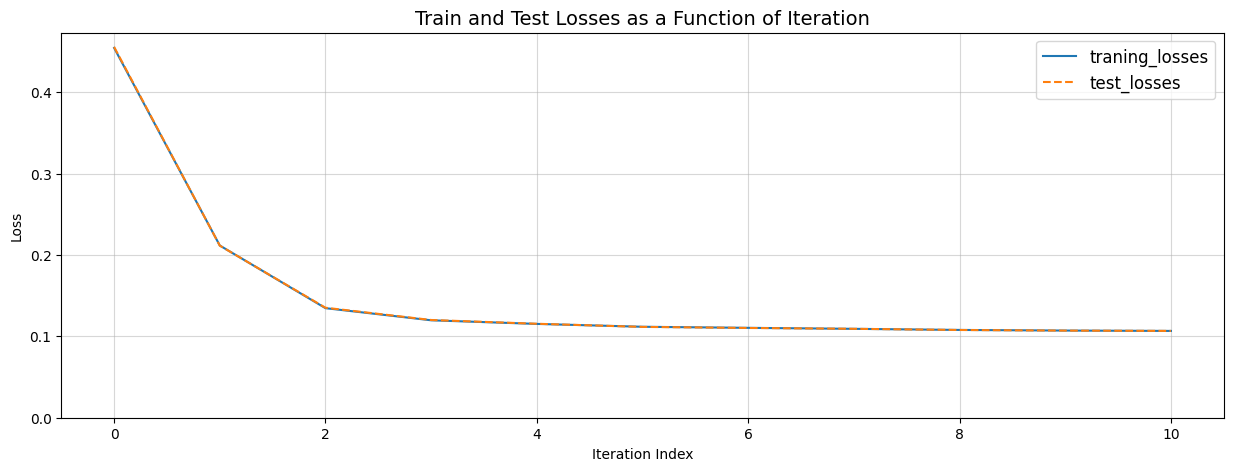

In [ ]:
plot_losses(np.mean(training_losses, axis=0), np.mean(test_losses, axis=0))

###Predict

**Define prediction function for Multiclass prediction**

In [ ]:
def predict(W, X):
  """
  Predict the class of each sample in X using the weight matrix W
  params:
    W: numpy array of shape (K, d+1), weight vectors as rows
    X: numpy array of shape (N, d+1), images matrix
    returns:
    y_pred: numpy array of shape (N,), predicted labels
  """
  predictions = X @ W.T
  y_pred = np.argmax(predictions, axis=1)
  return y_pred

**Make predictions**

In [ ]:
y_pred = predict(W, X_test)
y_test = np.argmax(y_test_onehot, axis=1)

###The Confusion Matrix


note: np.add.at: adds 1 in the confusion matrixs at the indces (predictions, actual), meaning the pairs (predictions[i], actual[i]) for i in range(len(actual))

In [ ]:
def Build_and_Display_CM(y_pred, y_test):
  """
  Build the confusion matrix
  params:
    y_pred: numpy array of shape (N,), predicted labels
    y_test_i: numpy array of shape (N,), actual labels
  """
  confusion_matrix = np.zeros(shape= (K, K), dtype= int)

  # Populate the confusion matrix using vectorized indexing
  np.add.at(confusion_matrix, (y_pred, y_test), 1)

  fig, axes = plt.subplots(1, K, figsize= (15, 3))  # Adjust figsize for better layout
  fig.suptitle("Confusion Matrices for Each Digit", fontsize= 16)

  # consructe and plot a confusion matrix for each digit
  for i in range(K):
      TP = confusion_matrix[i, i]
      FP = np.sum(confusion_matrix[:, i]) - TP
      FN = np.sum(confusion_matrix[i, :]) - TP
      TN = np.sum(confusion_matrix) - (TP + FP + FN)
      confusion_matrix_i = np.array([[TP, FP], [FN, TN]])

      # Create a subplot for each digit
      cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix_i, display_labels= ["P", "N"])
      cm_display.plot(ax= axes[i], colorbar= False)
      axes[i].set_title(f"Digit {i}", fontsize= 10)

  plt.tight_layout(rect= [0, 0, 1, 1])  # Adjust layout to fit the title
  plt.show()

  return confusion_matrix

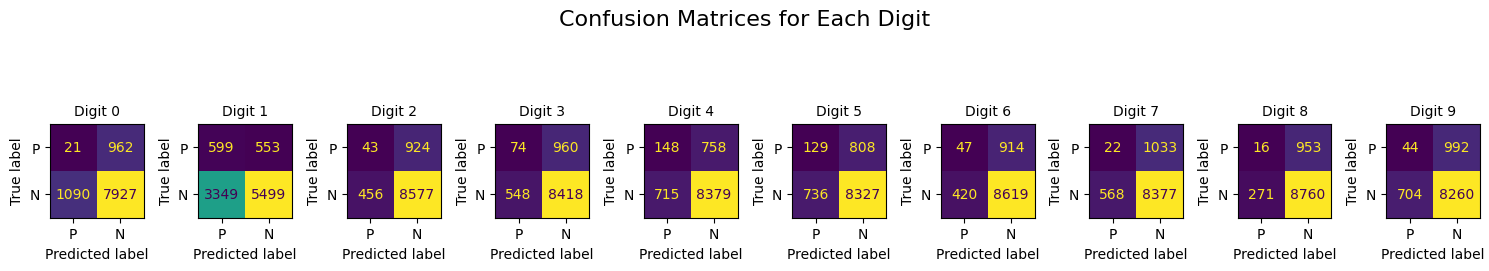

In [ ]:
confusion_matrix = Build_and_Display_CM(y_pred, y_test)

###Performance Matrices

In [ ]:
def Display_matrices(confusion_matrix):
  """
  Display the performance matrices
  params:
    confusion_matrix: numpy array of shape (K, K)
  """
  print('Class |  TP  |  FP  |  FN  |   TN  | Accuracy | Precision | Recall | F1 score')
  sumACC, sumTPR, sumTNR, sumF1 = 0, 0, 0, 0
  for k in range(K):
    TP = confusion_matrix[k, k]
    FP = np.sum(confusion_matrix[:, k]) - TP
    FN = np.sum(confusion_matrix[k, :]) - TP
    TN = np.sum(confusion_matrix) - (TP + FP + FN)
    ACC = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
    TPR = (TP) / (TP + FN) if (TP + FN) != 0 else 0
    TNR = (TN) / (TN + FP) if (TN + FP) != 0 else 0
    F1score = 2 * (TPR * ACC) / (TPR + ACC) if (TPR + ACC) != 0 else 0
    sumACC += ACC
    sumTPR += TPR
    sumTNR += TNR
    sumF1 += F1score
    print(f'{k:4}  | {TP:4} | {FP:4} | {FN:4} | {TN:4} | {ACC:8.3f} | {TPR:9.2f} | {TNR:6.2f} | {F1score:6.2f}')
  print(f'mean Accuracy:  {sumACC /K :.3f}')
  print(f'mean Precision: {sumTPR /K :.3f}')
  print(f'mean Recall:    {sumTNR /K :.3f}')
  print(f'mean F1 score:  {sumF1 /K :.3f}')

In [ ]:
Display_matrices(confusion_matrix)

Class |  TP  |  FP  |  FN  |   TN  | Accuracy | Precision | Recall | F1 score
   0  |   21 |  962 | 1090 | 7927 |    0.795 |      0.02 |   0.89 |   0.04
   1  |  599 |  553 | 3349 | 5499 |    0.610 |      0.15 |   0.91 |   0.24
   2  |   43 |  924 |  456 | 8577 |    0.862 |      0.09 |   0.90 |   0.16
   3  |   74 |  960 |  548 | 8418 |    0.849 |      0.12 |   0.90 |   0.21
   4  |  148 |  758 |  715 | 8379 |    0.853 |      0.17 |   0.92 |   0.29
   5  |  129 |  808 |  736 | 8327 |    0.846 |      0.15 |   0.91 |   0.25
   6  |   47 |  914 |  420 | 8619 |    0.867 |      0.10 |   0.90 |   0.18
   7  |   22 | 1033 |  568 | 8377 |    0.840 |      0.04 |   0.89 |   0.07
   8  |   16 |  953 |  271 | 8760 |    0.878 |      0.06 |   0.90 |   0.10
   9  |   44 |  992 |  704 | 8260 |    0.830 |      0.06 |   0.89 |   0.11
mean Accuracy:  0.823
mean Precision: 0.095
mean Recall:    0.902
mean F1 score:  0.165


###Discussion:

Note: High precision is achieved by having few false positives in the returned results, and high recall is achieved by having few false negatives in the relevant results.

**Accuracy** across digits ranges from 61.0% to 87.8%, showing good ability to distinguish between digits.

**Precision** is 9%, indicating a difficulty in avoiding false positives.

**Recall** is 90%, suggesting that the model is good at identifying the correct digit when it appears in the test set.

**F1-score** is 16%, reflecting the poor balance between precision and recall.

**Conclusion**


---


While the model achieves reasonable mean accuracy of 82.3%, its low precision and F1-scores suggest significant room for improvement.

##Part B: SoftMax Regression

###Define helper functions

**Softmax implementation notes:**
*   Gets a matrix z (N, K) and does a softmax on each row
*   Subtructing the max element prevents numerical overflow or underflow in the exponential computation.
*   keepdims is True for keeping the original dimantions and not reducing the dim by 1 as usual.
*   np.clip is used to ensure that the prob is never exactly zero for further log operation.

In [ ]:
def softmax(Z):
  """
  Softmax function
  params:
    Z: numpy array of shape (N, K)
  returns:
    probs: numpy array of shape (N, K)
  """
  Z -= np.max(Z, axis=1, keepdims=True)
  exp_Z = np.exp(Z)
  probs = exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
  np.clip(probs, 1e-10, 1.0, out= probs)

  return probs

**Categorical_cross_entropy_loss implementation notes:**
*   Copmutes loss
*   y_onehot * np.log(probs) acts as the indicator function

In [ ]:
def categorical_cross_entropy_loss(W, X, y_onehot):
  """
  Categorical cross-entropy loss function
  params:
    W: numpy array of shape (K, d+1)
    X: numpy array of shape (N, d+1)
    y_onehot: numpy array of shape (N, K)
  returns:
    loss: float
  """
  probs = softmax(X @ W.T)
  loss = - np.sum(y_onehot * np.log(probs))
  N = X.shape[0]

  return loss / N

**compute_gradients implementation notes:**
*   Computes the gradient

In [ ]:
def compute_gradients(W, X, y_onehot):
  """
  Compute the gradients
  params:
    W: numpy array of shape (K, d+1)
    X: numpy array of shape (N, d+1)
    y_onehot: numpy array of shape (N, K)
  returns:
    gradient: numpy array of shape (K, d+1)
  """
  probs = softmax(X @ W.T)
  gradient = (probs - y_onehot).T @ X
  N = X.shape[0]

  return gradient / N

###The Logistic Regression Algorithm for multi-class classification

In [ ]:
def logistic_regression(W, X_train, X_test, y_train_onehot, y_test_onehot, iterations=100, initial_lr=0.1, eta=0.8):
  """
  Logistic Regression Algorithm for multi-class classification
  params:
    W: numpy array of shape (K, d+1)
    X_train: numpy array of shape (N, d+1)
    X_test: numpy array of shape (N, d+1)
    y_train_onehot: numpy array of shape (N, K)
    y_test_onehot: numpy array of shape (N, K)
    iterations: number of iterations to perform
    initial_lr: initial learning rate
    eta: learning rate decay rate
  returns:
    training_losses: list of lists, each list contains the training loss for each class
    test_losses: list of lists, each list contains the test loss for each class
  """
  # init losses to empty
  training_losses = []
  test_losses = []

  lr = initial_lr # init learning rate
  initial_loss = categorical_cross_entropy_loss(W, X_train, y_train_onehot)

  for i in tqdm(range(iterations), desc="Logistic Regression"):

      gradients = compute_gradients(W, X_train, y_train_onehot)
      W += lr * (-gradients)  # Gradient descent update rule

      gradient_norm = np.linalg.norm(gradients) # norm of the gradients
      lr = eta * gradient_norm # update learning rate

      if i %10 == 0:
        curr_train_loss = categorical_cross_entropy_loss(W, X_train, y_train_onehot)
        training_losses.append(curr_train_loss)
        test_losses.append(categorical_cross_entropy_loss(W, X_test, y_test_onehot))
        print(f" curr loss: {round(curr_train_loss, 2)}")

  return training_losses, test_losses

**Run the Logistic Regression Algorithm**
*   init W to be close to 0.

*   iterations = 100. tested numbers between 50 and 200. 50 was insufficient, 200 was taking too long.

*   Initial learning rate = 0.1. tested numbers between 0.01 and 1. values close to 0.001 wasnt converging fast enough even with high number of epochs and values close to 1 was oscillating even with low eta.

*   eta = 0.8. tested numbers between 0.1 and 1. values close to 0.1 get too low after 50 iterations and values close to 1 wasnt reducing the learning rate fast enough.

*   Note: the norm of the gradient is at most sqrt(K * D) = sqrt(10 * 784) ~ 88.5

*   Insight: eta should be low becuse the learning rate needs to be between [0, 1].

In [ ]:
W = np.random.normal(loc= 0, scale= 1, size=(K, X_train.shape[1])) # init the w vector of each class to random values
training_losses, test_losses = logistic_regression(W, X_train, X_test, y_train_onehot, y_test_onehot, iterations=100, initial_lr=0.1, eta=0.8)

Logistic Regression:   0%|          | 0/100 [00:00<?, ?it/s]

 curr loss: 13.01
 curr loss: 3.22
 curr loss: 2.66
 curr loss: 2.41
 curr loss: 2.24
 curr loss: 2.11
 curr loss: 2.01
 curr loss: 1.92
 curr loss: 1.86
 curr loss: 1.8


###Plot Losses

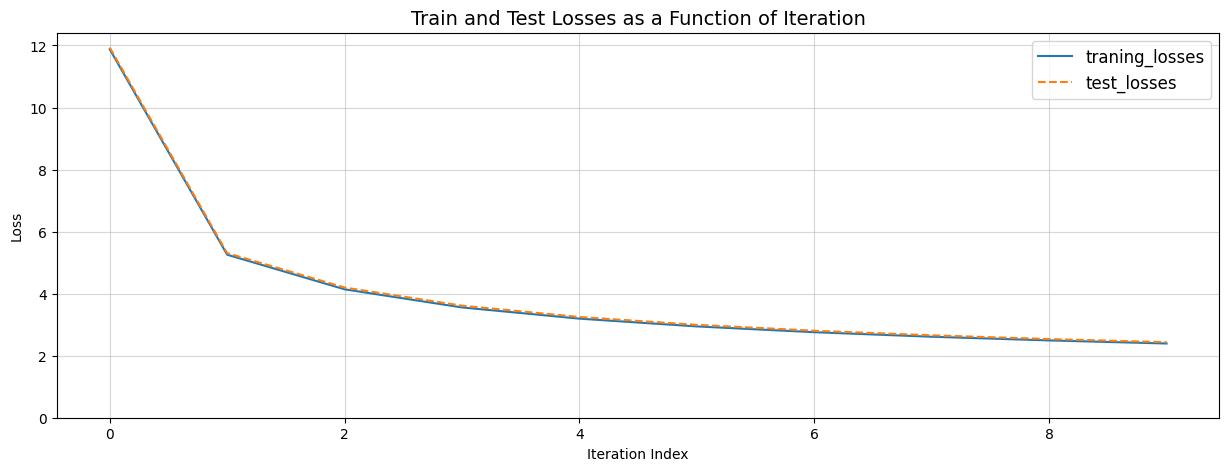

In [ ]:
plot_losses(list(training_losses), list(test_losses))

###Predict

In [ ]:
probs = softmax(X_test @ W.T)
y_pred = np.argmax(probs, axis=1)

###The Confusion Matrix


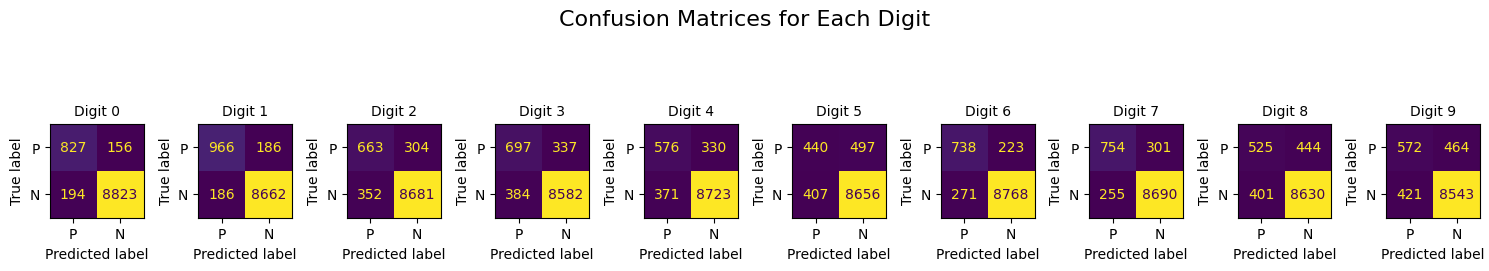

In [ ]:
confusion_matrix = Build_and_Display_CM(y_pred, y_test)

###Performance Matrices

In [ ]:
Display_matrices(confusion_matrix)

Class |  TP  |  FP  |  FN  |   TN  | Accuracy | Precision | Recall | F1 score
   0  |  827 |  156 |  194 | 8823 |    0.965 |      0.81 |   0.98 |   0.88
   1  |  966 |  186 |  186 | 8662 |    0.963 |      0.84 |   0.98 |   0.90
   2  |  663 |  304 |  352 | 8681 |    0.934 |      0.65 |   0.97 |   0.77
   3  |  697 |  337 |  384 | 8582 |    0.928 |      0.64 |   0.96 |   0.76
   4  |  576 |  330 |  371 | 8723 |    0.930 |      0.61 |   0.96 |   0.74
   5  |  440 |  497 |  407 | 8656 |    0.910 |      0.52 |   0.95 |   0.66
   6  |  738 |  223 |  271 | 8768 |    0.951 |      0.73 |   0.98 |   0.83
   7  |  754 |  301 |  255 | 8690 |    0.944 |      0.75 |   0.97 |   0.83
   8  |  525 |  444 |  401 | 8630 |    0.915 |      0.57 |   0.95 |   0.70
   9  |  572 |  464 |  421 | 8543 |    0.911 |      0.58 |   0.95 |   0.71
mean Accuracy:  0.935
mean Precision: 0.670
mean Recall:    0.964
mean F1 score:  0.777


###Discussion:

**Accuracy** is 93%, showing great ability to distinguish between digits.

**Precision** ranges between 52% - 84% and is notably low for all classes, indicating a difficulty in avoiding false positives.

**Recall** is 96% across all classes, suggesting that the model is excellent at identifying true instances of each digit when they appear, meaning it does not miss many true positives.

**F1 score** is 77%, indicating a good balance between precision and recall.

**Conclusion**


---


While the model achieves reasonable mean accuracy of 93.5%, its low precision suggest significant room for improvement.

##Part C: Linear Regression

###The Linear Regression Algorithm

note: instead of y being a (N,) vector, its now (N, K) and the result is (D, K) meaning we need to transpose to get W = (K, D).

In [ ]:
def linear_regression(X_train, y_train_onehot):
    return (np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train_onehot).T

**Run the Linear Regression Algorithm**

In [ ]:
W = linear_regression(X_train, y_train_onehot)

###Predict

**Make predictions**

In [ ]:
y_pred = predict(W, X_test)

###The Confusion Matrix

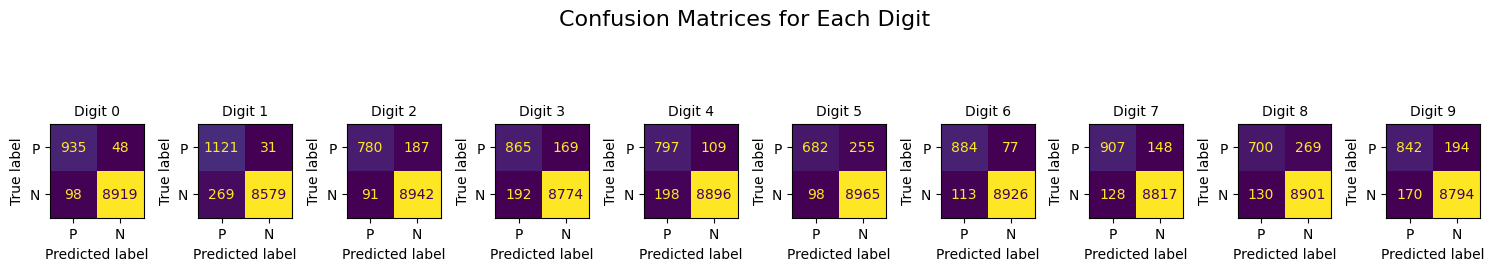

In [ ]:
confusion_matrix = Build_and_Display_CM(y_pred, y_test)

###Performance Matrices

In [ ]:
Display_matrices(confusion_matrix)

Class |  TP  |  FP  |  FN  |   TN  | Accuracy | Precision | Recall | F1 score
   0  |  935 |   48 |   98 | 8919 |    0.985 |      0.91 |   0.99 |   0.94
   1  | 1121 |   31 |  269 | 8579 |    0.970 |      0.81 |   1.00 |   0.88
   2  |  780 |  187 |   91 | 8942 |    0.972 |      0.90 |   0.98 |   0.93
   3  |  865 |  169 |  192 | 8774 |    0.964 |      0.82 |   0.98 |   0.89
   4  |  797 |  109 |  198 | 8896 |    0.969 |      0.80 |   0.99 |   0.88
   5  |  682 |  255 |   98 | 8965 |    0.965 |      0.87 |   0.97 |   0.92
   6  |  884 |   77 |  113 | 8926 |    0.981 |      0.89 |   0.99 |   0.93
   7  |  907 |  148 |  128 | 8817 |    0.972 |      0.88 |   0.98 |   0.92
   8  |  700 |  269 |  130 | 8901 |    0.960 |      0.84 |   0.97 |   0.90
   9  |  842 |  194 |  170 | 8794 |    0.964 |      0.83 |   0.98 |   0.89
mean Accuracy:  0.970
mean Precision: 0.854
mean Recall:    0.984
mean F1 score:  0.908


###Discussion:

**Accuracy** is 97%, showing great ability to distinguish between digits.

**Precision** is 85%, indicating a sight difficulty in avoiding false positives.

**Recall** is 98% and above 97% across al classes, suggesting that the model is excellent at identifying true instances of each digit when they appear, meaning strog ability to minimize false negatives.

**F1 score** is 90%, indicating a good balance between precision and recall.

**Conclusion**


---


The model achieves mean accuracy of 97% that reflects excellent detection across all classes. However, there is still room to improve precision.

*   Strengths: Simple, fast, and provides high accuracy for classification tasks like MNIST.
*   Weaknesses: Limited by linear decision boundaries and struggles with more complex data structures. Non-linear patterns in MNIST reduce its performance.

**Comparison**


---


*   Linear Regression has he best metricies out of the preceptron and the softmax models.